# The numbers behind Formula One champions

On this notebook, I will analise several statistics of Formula One's most succesfull drivers. The covered topics will be:
* The top 10 drivers with the most wins
* How the definition of a successfull driver changed over the years
* The influence the team has over a driver's success
* Interesting bits of data

For this analysis, I will be using ergast's database. More info about it can be found at http://ergast.com/mrd/

We will not be making any API requests here. The data used is stored in the data folder, and was obtained from the API in the data-scripts.ipynb notebook.

In [5]:
# Standart imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as pld
import pandas as pd
import seaborn
import json

## Top 10 best drivers

In this section, we analyze the 10 drivers who won the most.

First, let's see which seasons the API has data of.

In [2]:
seasons_file = open("./data/seasons.json")
seasons_data = json.load(seasons_file)
list_of_seasons = []
for season in seasons_data["MRData"]["SeasonTable"]["Seasons"]:
    list_of_seasons.append(season["season"])
print(len(list_of_seasons))
seasons_file.close;

73


F1's first season was back in 1950. So the database used has all seasons logged.

Now, let's see an example of how to get all the winners of a season, and then graph it.

In [3]:
# First write the names of the winners, then count how many times each pearson occurs on the list
file_2008 = open("./data/2008-season.json")
season_2008_data = json.load(file_2008)
winners_2008 = []
for race in season_2008_data["MRData"]["RaceTable"]["Races"]:
    winners_2008.append(race["Results"][0]["Driver"]["code"])

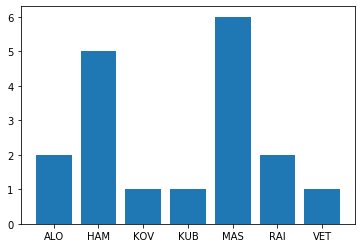

In [4]:
drivers, nmbr_wins = np.unique(winners_2008, return_counts=True)
plt.bar(x=drivers, height=nmbr_wins, align="center");

So we see that Felipe Massa won one more race than Lewis Hamilton, but still lost the 2008 championship.

Now, let's try to do the same, but for every season in Formula 1.

In [5]:
# Create a dict with everyone's names as keys, and their win count as values.
winners_dict = {}
for year in range(1950, 2023):
    season_file = open(f"./data/all-seasons-results/{year}.json")
    season_data = json.load(season_file)
    for race in season_data["MRData"]["RaceTable"]["Races"]:
        try:
            winners_dict[race["Results"][0]["Driver"]["givenName"]+" "+race["Results"][0]["Driver"]["familyName"]] += 1
        except:
            winners_dict[race["Results"][0]["Driver"]["givenName"]+" "+race["Results"][0]["Driver"]["familyName"]] = 1


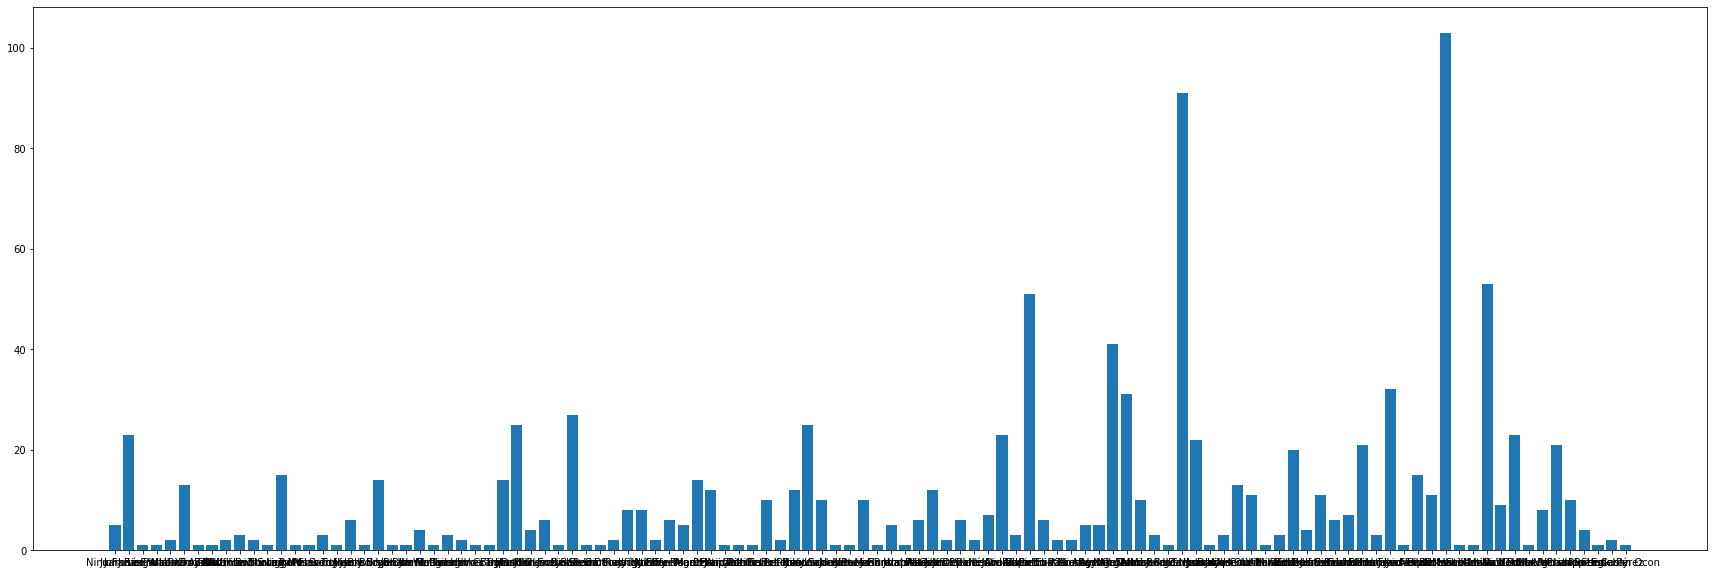

In [6]:
# Let's get a quick overview of our data
plt.subplots(figsize=(30,10))
plt.bar(x=winners_dict.keys(), height=winners_dict.values(), align="center");

In [7]:
# Making a DataFrame to make things clearer
driver_series = pd.Series(winners_dict.keys())
wins_series = pd.Series(winners_dict.values())
test = {
    "Drivers":driver_series,
    "Wins":wins_series
}
wincount_df = pd.DataFrame(test)
wincount_df

,Drivers,Wins
0,Nino Farina,5
1,Juan Fangio,23
2,Johnnie Parsons,1
3,Lee Wallard,1
4,José Froilán González,2
...,...,...
105,Valtteri Bottas,10
106,Charles Leclerc,4
107,Pierre Gasly,1
108,Sergio Pérez,2


In [8]:
# Now let's see the top 10 winners.
sorted_wincount_df = wincount_df.sort_values("Wins", ascending=False, axis=0)
top_10_df = sorted_wincount_df[:10]
top_10_df

,Drivers,Wins
96,Lewis Hamilton,103
77,Michael Schumacher,91
99,Sebastian Vettel,53
66,Alain Prost,51
72,Ayrton Senna,41
92,Fernando Alonso,32
73,Nigel Mansell,31
33,Jackie Stewart,27
50,Niki Lauda,25
29,Jim Clark,25


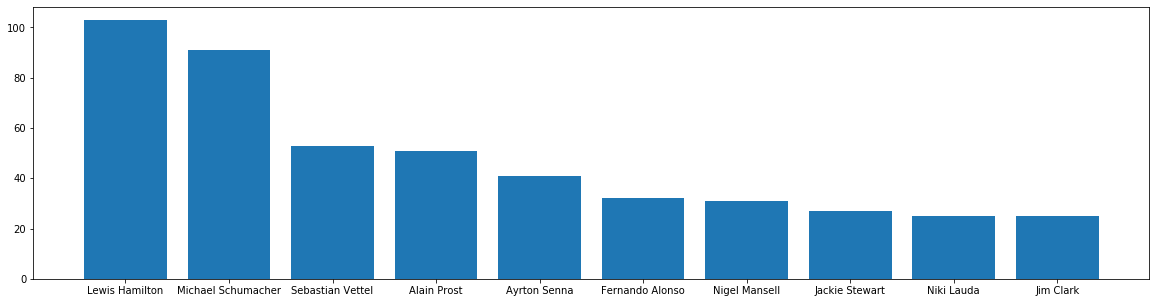

In [9]:
# Making a graph of these guys
plt.subplots(figsize=(20,5))
plt.bar(x=top_10_df.Drivers, height=top_10_df.Wins);

This graph shows us the 10 drivers who won the most races. With only this info at hand, one might say that these are the best drivers Formula 1 has ever had.

But this misses a critical point: How the sport changed over the years.

## How the definition of a succesfull driver changed over the years

To have a better understanding of how dominant a driver was, we need to consider the state of the sport back when they were driving.

### Races per season

This is probably the most important factor. Lewis Hamilton and Michael Schumacher would probably have a much harder time getting 90~100 race wins back in 1980, as back then there were only 14 races per season.

With this in mind, let's see how the number of races per season has changed over the years.

In [10]:
# Let's use a dictionary to store this data
races_per_season = {}
# This time we don't want to include the 2022 season, as it is not over.
for year in range(1950, 2022):
    season_file = open(f"./data/all-seasons-results/{year}.json")
    season_data = json.load(season_file)
    races_per_season[year] = 0
    for race in season_data["MRData"]["RaceTable"]["Races"]:
        races_per_season[year] += 1

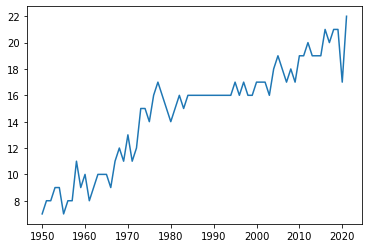

In [11]:
plt.plot(list(races_per_season.keys()), list(races_per_season.values()));

Notice the upward trend. In the first decades, there were barely 10 races a year. If Hamilton was to get his 100 wins back then, he would need to win a decade's worth of championships first. This would be extremely unlikely, since the car regulations change after every season, and a team that has a good car for one year might not have one for the next.

This is why well-known drivers such as Juan Fangio or Alberto Ascari are not in the top 10: They simply did not have enough races per season to do so. Furthermore, the regulation changes after each year were massive, since the engineers were still discovering the importance of downforce, and different ways of achieving it. As a result, it was unusual for a team to do well for more than a couple of years. This makes it even more impressive when someone who raced in those early years, such as Niki Lauda or Jim Clark, does appear in the top 10.

Sidenote: Notice how covid-19 impacted the graph during the 2020 season: We went back to having as many races as we had back in the late 2000s.

### Average driver age throughout the years

It is important to analyze this data, as every sporstsmen has an "expiration date"; when their bodies simply aren't up to the task anymore. Which means that the earlier someone starts at F1, the more races they can have before retiring. 

This wasn't really a concern back in the 50s, as the sport was still growing, and every driver was old enough to be a dad. Nowadays, the 2021 champion started on F1 when he was just 17 years old. And he started go-karting when he was just 4 years old.

To analyze this data, we will analyze two averages: The average of the whole grid, and the average of the championship winner.

To prevent the code from making too many API calls, we will not analyze the age of all drivers in all the races of a season. Instead, we will only look at the first race of the season, and draw our year-average from there.

In [12]:
# Let's store the data on a dict
driver_avg_age = {}
for year in range(1950, 2023):
    season_file = open(f"./data/all-seasons-first-races/{year}.json")
    season_data = json.load(season_file)
    year_average = 0
    total_drivers = 0
    sum_of_age = 0
    for driver in season_data["MRData"]["RaceTable"]["Races"][0]["Results"]:
        # Get the year they were born in, and subtract to find how old they were
        sum_of_age += year - int(driver["Driver"]["dateOfBirth"][:4])
        total_drivers += 1
    year_average = sum_of_age/total_drivers
    driver_avg_age[year] = year_average

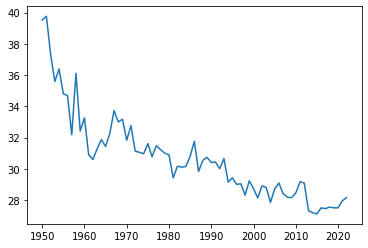

In [13]:
# Make the data more visual
plt.plot(list(driver_avg_age.keys()), list(driver_avg_age.values()));

The average difference between a current F1 driver and one from 1960s is around 5 years. Of course there are outliers, such as Lewis Hamilton winning his 100th GP at the "old" age of 36. But the trend is clear: the drivers are getting younger, and as a result they have more time to break records.

## Team's influence over a driver success

Perhaps the most important factor of all: the driver's team. They are the ones responsible  behind the car that each world champion used to win. No one in the history of F1 managed to win a championship with a below average car.

The tricky part is: how can you say that a driver's win was because of the car, not because of skill? 

The answer is that you can't really do that. Many factors need to be taken into consideration when deciding if a car is good or not; you would need to have a team of engineers analyzing each car's blueprints to arrive at an educated conclusion. Add to that the amount of seasons we had, and accurately analyzing if a driver's success was down to skill or engineering is basically impossible.

With that said, we can make some guesses.

The main point we are going to analyze is the other championship that happens in F1: the World Constructors' Championship. While the World Driver's Championship mostly comes down to one driver only, the constructors' relies on the teammate as well. If a team has one good driver and a bad driver, they might win the WDC, but they will most likely lose the WCC. They need both drivers scoring points throughout the season to get the WCC.

For the following data analysis, we will assume that it's unlikely for a team to have 2 extremely good drivers. This means that, if a team won the WCC, it was because they just had the better car all around. So if the team managed to win just the WDC, but not the WCC, it is an indicator that driver's skill played a role on the championship result.

Of course this is prone to errors. For instance: for a couple of seasons McLaren had both Ayrton Senna and Alain Prost as their drivers, and both of them are in the top 10 wins list and are in the discussion of being the greatest of all time. During those years, they also constructed what turned out to be the most dominant car of all time: the MP4/4, winning 15 out of the 16 races of 1988. This would lead us to believe that the 1988 WDC was decided at the factory, and that Senna (who won the WDC that year) wasn't necessarily good. But then again, scenarios like this almost never happened again.

In [14]:
# Let's use a dictionary to store this data
is_wdc_also_wcc = {}
# The constructors championship was not awarded until 1958. So the first year needs to be 1958
for year in range(1958, 2022):
    drivers_file = open(f"./data/all-seasons-driverstandings/{year}.json")
    teams_file = open(f"./data/all-seasons-constructorstandings/{year}.json")
    drivers_data = json.load(drivers_file)
    teams_data = json.load(teams_file)
    
    # The team who won the wdc
    wdc_winner = drivers_data["MRData"]["StandingsTable"]["StandingsLists"][0]["DriverStandings"][0]["Constructors"][0]["constructorId"]
    # The team who won the wcc
    wcc_winner = teams_data["MRData"]["StandingsTable"]["StandingsLists"][0]["ConstructorStandings"][0]["Constructor"]["constructorId"]
    if wdc_winner == wcc_winner:
        is_wdc_also_wcc[year] = 1
    else:
        is_wdc_also_wcc[year] = 0

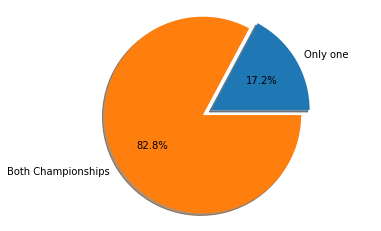

In [15]:
wdc_is_wcc_percent = np.average(list(is_wdc_also_wcc.values()))
explode = (0,0.1)
labels = ["Only one","Both Championships"]
fig, ax1 = plt.subplots()
ax1.pie([1-wdc_is_wcc_percent,wdc_is_wcc_percent],explode=explode,labels=labels,autopct='%1.1f%%',shadow=True);
ax1.axis("equal");

This graph shows us the expected: Most of the times, if a driver wins the wdc, the team wins the wcc as well.

This means that, in order to win, a driver must have an atleast somewhat competitive car.

## Most successful teams over the years

In this section, we how each team has performed over the decades.

Let's first create a list with all teams who won at least one WCC.


In [16]:
constructors_wins = {}

# Creating the team's lists with every team to win a wcc
teams_file = open(f"./data/constructors-1.json")
teams_data = json.load(teams_file)
all_teams = teams_data["MRData"]["ConstructorTable"]["Constructors"]
for team in all_teams:
    constructors_wins[team["constructorId"]] = []
constructors_wins


{'benetton': [],
 'brabham-repco': [],
 'brawn': [],
 'brm': [],
 'cooper-climax': [],
 'ferrari': [],
 'lotus-climax': [],
 'lotus-ford': [],
 'matra-ford': [],
 'mclaren': [],
 'mercedes': [],
 'red_bull': [],
 'renault': [],
 'team_lotus': [],
 'tyrrell': [],
 'vanwall': [],
 'williams': []}

Now let's populate those lists.

In [17]:
# Filling the team's lists
for year in range(1958, 2022):
    teams_file = open(f"./data/all-seasons-constructorstandings/{year}.json")
    teams_data = json.load(teams_file)
    winner_team = teams_data["MRData"]["StandingsTable"]["StandingsLists"][0]["ConstructorStandings"][0]["Constructor"]["constructorId"]
    for team in constructors_wins.keys():
        if team != winner_team:
            try:
                constructors_wins[team].append(max(constructors_wins[team]))
            except:
                constructors_wins[team].append(0)
    try:
        constructors_wins[winner_team].append(max(constructors_wins[winner_team])+1)
    except:
        constructors_wins[winner_team].append(1)

Let's first see how each team has performed throughout the years:

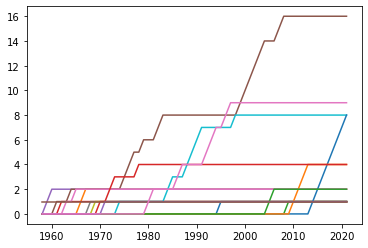

In [18]:
for team,wins_list in constructors_wins.items():
    plt.plot(range(1958,2022), wins_list)

Now, let's see the total of WCCs each team has.

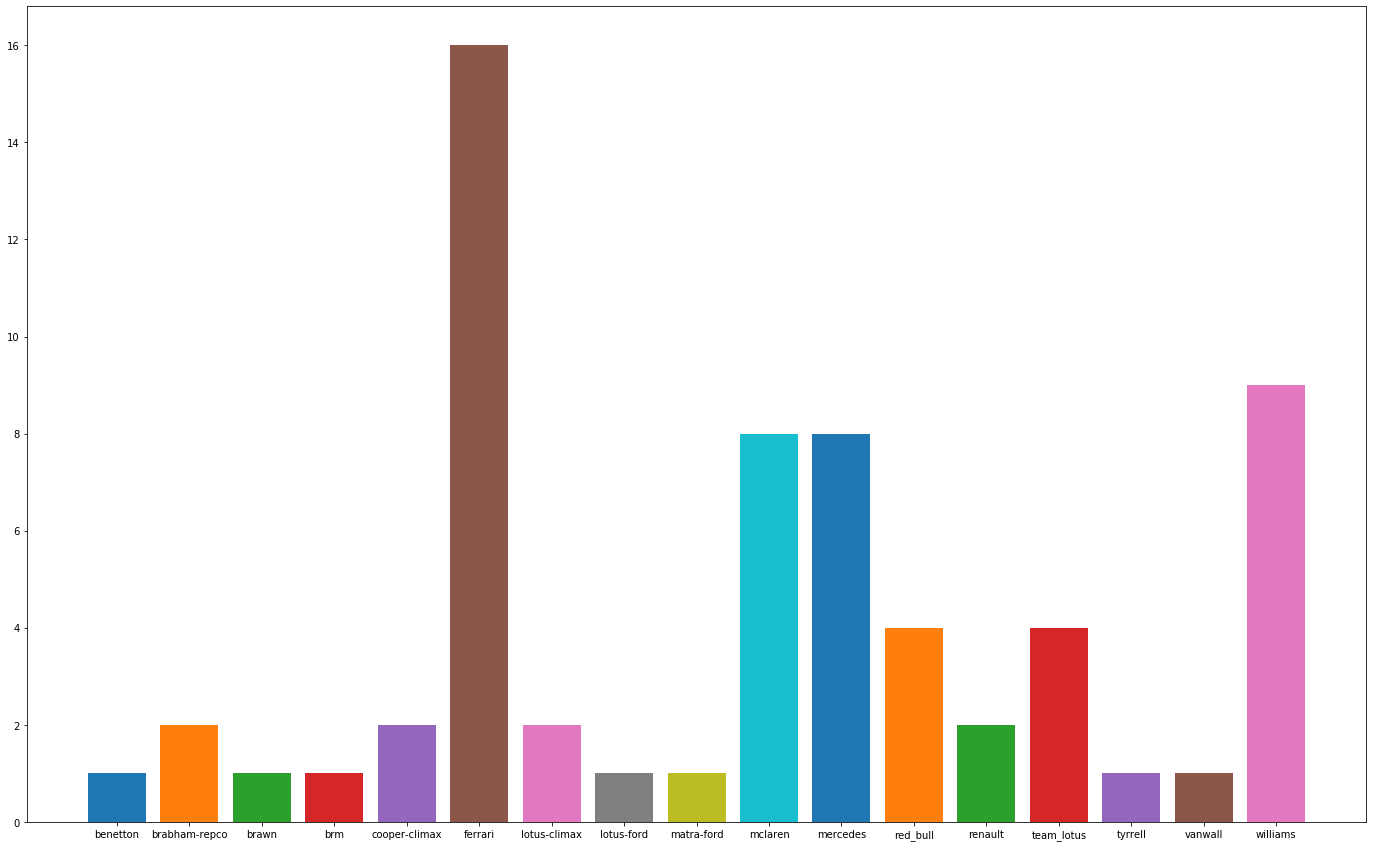

In [19]:
plt.subplots(figsize=(24,15))
for key,values in constructors_wins.items():
    plt.bar(key, max(values))

As we can see, Ferrari dominates the sport, by far. The other outliers are Williams, who despite their current position have had their fair share of wins in the past, McLaren and Mercedes.

It's interesting to see how most of Mercedes' wins came from the turbo-hybrid era, from Hamilton and Rosberg.

## Interesting bits of data

In this section, we dive into some f1 factoids.

### Analysing changes to F1 regulations

In this section, we try to see the results of the changes done by the FIA to promote closer racing.

The FIA has been trying to make each race more exciting, by promoting changes to the cars to allow them to race closer to one another. These changes are not only to the car itself, but for the teams too. In 2021, an investment cap has been forced on the teams, which allows them to only spend up to 100M euros on the development of their car. This makes it so that big teams like Mercedes and Ferrari can't just completely outclass smaller teams like Haas by investing three times more on their car.

To start, we will look at raw speed alone. For this, let's look at the lap times during qualifying on the Italian Grand Prix, or more specifically, on Monza. 

This track is one of the only ones to appear in every single F1 season since 1950 (only absent in 1980, when the Italian GP was held at Imola), and is not known as "The Temple of Speed" for nothing: it is the fastest track on the F1 calendar. In 2020, Lewis Hamilton set a lap with an average speed of 264 km/h.

We expect to see an upwards trend, as the laptimes get slower.

In [28]:
# Getting the monza laptimes on a dictionary
monza_laptimes = {}
for year in range(2003, 2022):
    monza_file = open(f"./data/2003-2021-monza-laptimes/{year}.json")
    monza_data = json.load(monza_file)
    first_driver = monza_data["MRData"]["RaceTable"]["Races"][0]["QualifyingResults"][0]
    fastest_quali_section = list(first_driver.keys())[-1]
    fastest_lap = first_driver[fastest_quali_section]
    monza_laptimes[year] = fastest_lap
monza_laptimes

{2003: '1:20.963',
 2004: '1:20.089',
 2005: '1:20.878',
 2006: '1:21.484',
 2007: '1:21.997',
 2008: '1:37.555',
 2009: '1:24.066',
 2010: '1:21.962',
 2011: '1:22.275',
 2012: '1:24.010',
 2013: '1:23.755',
 2014: '1:24.109',
 2015: '1:23.397',
 2016: '1:21.135',
 2017: '1:35.554',
 2018: '1:19.119',
 2019: '1:19.307',
 2020: '1:18.887',
 2021: '1:19.555'}

In [16]:
# Making the same dict but with seconds, to make the graph more readable
laptimes_seconds = {}
for year, laptime in monza_laptimes.items():
    laptimes_seconds[year] = int(laptime[0])*60 + int(laptime[2:4]) + int(laptime[5:])/1000

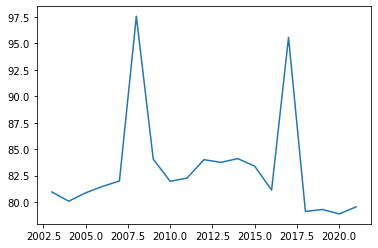

In [17]:
# Graphing the laptimes
plt.plot(list(laptimes_seconds.keys()), list(laptimes_seconds.values()));

Roughly speaking, there have been no changes to the laptimes. If anything, they are getting faster!

Note: The outliers are probably because the qualifying was ended abruptly, usually due to a red flag caused by an accident.

Maybe we need to look at another track. Monza is too focused on engine power, and thus maybe won't reflect how the changes to the car aerodynamics have changed the sport.

With this in mind, let's look at laptimes around the Belgian Grand Prix, or more specifically, Spa. This is one of the most balanced tracks on the calendar, and requires both straight line power and good cornering speed.

We once again expect an upwards trend, as the laptimes get slower.

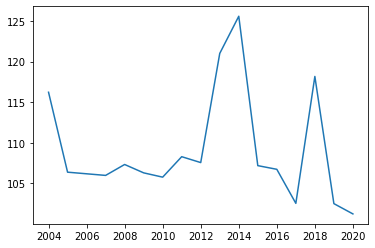

In [6]:
# Getting the laptimes from the data folder
spa_laptimes = {}
for year in range(2004, 2021):
    if year == 2006: # We didn't have a Belgian GP in this year
        year += 1
    spa_file = open(f"./data/2004-2021-spa-laptimes/{year}.json")
    spa_data = json.load(spa_file)
    first_driver = spa_data["MRData"]["RaceTable"]["Races"][0]["QualifyingResults"][0]
    fastest_quali_section = list(first_driver.keys())[-1]
    fastest_lap = first_driver[fastest_quali_section]
    spa_laptimes[year] = fastest_lap
# Making a new dict with seconds to make the graph
laptimes_seconds = {}
for year, laptime in spa_laptimes.items():
    laptimes_seconds[year] = int(laptime[0])*60 + int(laptime[2:4]) + int(laptime[5:])/1000

# Plotting it
plt.plot(list(laptimes_seconds.keys()), list(laptimes_seconds.values()));

Here we kind of see the opposite of what was expected: the laptimes got ever so slightly faster over time.

So apparently the changes made by the FIA have done mostly nothing to the sport, since the upwards trend we expected never occurred.

But let's look at one last factor: the gap between the fastest car, and the slowest. Again, we will first look at Monza, and then Spa to be sure.

We expect this gap to decrease, as the grid gets closer.

In [28]:
monza_deltas = {}
for year in range(2003, 2022):
    monza_file = open(f"./data/2003-2021-monza-laptimes/{year}.json")
    monza_data = json.load(monza_file)
    # Get the first place's time and turn it to seconds
    first_driver = monza_data["MRData"]["RaceTable"]["Races"][0]["QualifyingResults"][0]
    fastest_quali_section = list(first_driver.keys())[-1]
    fastest_lap = first_driver[fastest_quali_section]
    first_place = int(fastest_lap[0])*60 + int(fastest_lap[2:4]) + int(fastest_lap[5:])/1000
    # Get the fifth place's time and turn it to seconds
    fifth_driver = monza_data["MRData"]["RaceTable"]["Races"][0]["QualifyingResults"][4]
    fifths_fastest_quali_section = list(fifth_driver.keys())[-1]
    fifths_fastest_lap = fifth_driver[fifths_fastest_quali_section]
    fifth_place = int(fifths_fastest_lap[0])*60 + int(fifths_fastest_lap[2:4]) + int(fifths_fastest_lap[5:])/1000
    
    delta = fifth_place - first_place
    monza_deltas[year] = delta


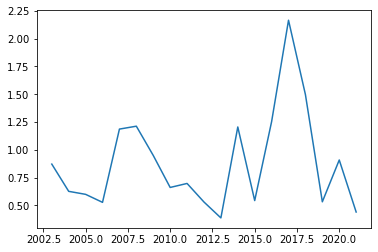

In [29]:
plt.plot(list(monza_deltas.keys()), list(monza_deltas.values()));

In [12]:
spa_deltas = {}
for year in range(2004, 2022):
    if year == 2006:
        year += 1
    spa_file = open(f"./data/2004-2021-spa-laptimes/{year}.json")
    spa_data = json.load(spa_file)
    # Get the first place's time and turn it to seconds
    first_driver = spa_data["MRData"]["RaceTable"]["Races"][0]["QualifyingResults"][0]
    fastest_quali_section = list(first_driver.keys())[-1]
    fastest_lap = first_driver[fastest_quali_section]
    first_place = int(fastest_lap[0])*60 + int(fastest_lap[2:4]) + int(fastest_lap[5:])/1000
    # Get the fifth place's time and turn it to seconds
    fifth_driver = spa_data["MRData"]["RaceTable"]["Races"][0]["QualifyingResults"][4]
    fifths_fastest_quali_section = list(fifth_driver.keys())[-1]
    fifths_fastest_lap = fifth_driver[fifths_fastest_quali_section]
    fifth_place = int(fifths_fastest_lap[0])*60 + int(fifths_fastest_lap[2:4]) + int(fifths_fastest_lap[5:])/1000
    
    delta = fifth_place - first_place
    spa_deltas[year] = delta
spa_deltas

{2004: 1.808000000000007,
 2005: 0.3689999999999998,
 2007: 1.3400000000000034,
 2008: 0.9770000000000039,
 2009: 0.2779999999999916,
 2010: 0.42799999999999727,
 2011: 2.254000000000005,
 2012: 0.6460000000000008,
 2013: 1.3199999999999932,
 2014: 2.3200000000000074,
 2015: 1.402000000000001,
 2016: 0.4719999999999942,
 2017: 0.8269999999999982,
 2018: 3.942999999999998,
 2019: 1.1709999999999923,
 2020: 1.0120000000000005,
 2021: 1.1700000000000017}

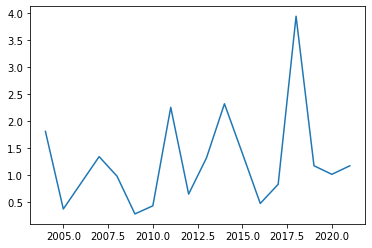

In [13]:
plt.plot(list(spa_deltas.keys()), list(spa_deltas.values()));